In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces

grid_size = 10
class SnakeGridEnv(gym.Env):
    def __init__(self, grid_size):
        super(SnakeGridEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=0, high=grid_size-1, shape=(2,), dtype=np.int32)
        self.reward_map = None
        self.step_counter = 0
        self.reset()

    def reset(self):
        self.state = np.array([0, 0]) # Starting at top-left corner
        self.initialize_reward_map()
        self.step_counter = 0  # Reset the step counter at the start of each episode
        return self.state

    def initialize_reward_map(self):
        self.reward_map = np.full((self.grid_size, self.grid_size), -100)
        self.reward_map[:, self.state[1]] = 100  # Set the starting column to 0
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100
    
    def step(self, action):
        # Initialize done as False
        done = False

        # Action mappings (no changes here)
        action_mappings = {
            0: (-1, 0),  # Move up
            1: (1, 0),   # Move down
            2: (0, -1),  # Move left
            3: (0, 1)    # Move right
        }

        # Update state based on action (no changes here)
        delta = action_mappings.get(action, (0, 0))
        new_state = np.array([self.state[0] + delta[0], self.state[1] + delta[1]])

        # Check and handle boundary conditions
        if new_state[0] < 0 or new_state[0] >= self.grid_size or new_state[1] < 0 or new_state[1] >= self.grid_size:
            # Agent tried to move off bounds, give a negative reward
            reward = -10  # You can adjust the reward value as needed
            done = True  # Mark the episode as done
        else:
            # Check if the agent has moved to a new column (no changes here)
            previous_column = self.state[1]
            new_column = new_state[1]
            if previous_column != new_column:
                if np.all(self.reward_map[:, new_column] == -1):
                    # Move to the rightmost column if available
                    if new_column < self.grid_size - 1:
                        new_state[1] = self.grid_size - 1
                else:
                    # Explore the new column from top to bottom
                    while new_state[0] < self.grid_size and self.reward_map[new_state[0], new_column] == -1:
                        new_state[0] += 1

            # Update state (no changes here)
            self.state = new_state

            # Increment the step counter (no changes here)
            self.step_counter += 1

            # Calculate reward, mark cell, check done (no changes here)
            reward = self.calculate_reward()
            self.reward_map[self.state[0], self.state[1]] = -1

            # Ensure the agent only goes up or down when at the top or bottom of a column (no changes here)
            if action == 0 and new_state[0] > 0:
                reward = -1  # Give a negative reward for moving up inside a column
            elif action == 1 and new_state[0] < self.grid_size - 1:
                reward = -1  # Give a negative reward for moving down inside a column

            done = self.is_done()

        print(f"Step:{self.step_counter}, action: {action}, State: {self.state}, Reward: {reward}, Done: {done}")
        return self.state, reward, done, {}


        
    def calculate_reward(self):
        # Check if the agent has reached the bottom of the grid
        if self.state[0] == self.grid_size - 1:
            return 100
        return self.reward_map[self.state[0], self.state[1]]
    
    def update_reward_map_for_new_column(self):
        x = self.state[0]
        y = self.state[1]

        # Check if the agent has reached the bottom of the grid
        if x == self.grid_size - 1:
            return

        # Check if the agent has completed the previous column
        if y > 0 and np.all(self.reward_map[:, y - 1] == -1):
            # Reset the agent's position to the rightmost column
            self.state[1] = self.grid_size - 1
            y = self.state[1]

        # Set all cells in the current column to 0 (undiscovered cells)
        self.reward_map[:, y] = 0

        # Set the current cell as visited
        self.reward_map[x, y] = -1

        # Set the reward for moving to the right
        if y < self.grid_size - 1:
            self.reward_map[x, y + 1] = 100  # Move to the right

    # def update_reward_map_for_new_column(self):
    #     self.reward_map[:, :] = -100  # Set all cells to -100
    #     self.reward_map[:, self.state[1]] = 0  # Set cells in the current column to 0
        

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = 100  # Example step limit
        return np.all(self.reward_map == -1) or self.step_counter >= max_steps
        
    def render(self, mode='human'):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reward_map, cmap='viridis', origin='lower')
        plt.scatter(self.state[1], self.state[0], c='red', marker='o')  # Agent's position
        plt.title("Agent's movement in Grid")
        plt.pause(0.1)  # Pause for a short period to create animation effect
        
def train_agent(env, agent, episodes):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        if (episode % 10 == 0):
            print(f"Episode {episode}: Total Reward: {total_reward}")

    print("Training complete.")

class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon=0.1, gasoline_capacity=100, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((env.grid_size, env.grid_size, env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Random action
        else:
            state_index = (state[0], state[1])
            action = np.argmax(self.q_table[state_index])
        return action
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error

    def train(self, episodes):
        for _ in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.learn(state, action, reward, next_state)
                state = next_state

# Train the agent
env = SnakeGridEnv(grid_size=10)
agent = QLearningAgent(env)
train_agent(env, agent, episodes=1000)

def animation_plot(env, ax):
    ax.clear()
    ax.imshow(env.reward_map, cmap='viridis', alpha=0.8)
    ax.scatter(env.state[1], env.state[0], color='red', label='Agent', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()

print(env.reward_map)
def update(frame, env, agent, ax):
    if not hasattr(update, "done") or not update.done:
        action = agent.choose_action(env.state)
        _, _, update.done, _ = env.step(action)
        animation_plot(env, ax)

fig, ax = plt.subplots()

# Reset the environment for the animation
env.reset()

# Create the animation
animation = FuncAnimation(fig, lambda frame: update(frame, env, agent, ax), frames=100, interval=100)

# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())
def plot_q_values(agent):
    fig, axs = plt.subplots(agent.env.grid_size, agent.env.grid_size, figsize=(20, 20))

    # Iterate over all grid cells
    for i in range(agent.env.grid_size):
        for j in range(agent.env.grid_size):
            ax = axs[i, j]
            q_values = agent.q_table[i, j]

            # Use a bar chart or similar to represent Q-values for each action
            ax.bar(range(len(q_values)), q_values, color=['blue', 'green', 'red', 'purple'])
            ax.set_ylim([-100, 100])  # Assuming Q-values are in this range; adjust as needed
            ax.set_xticks(range(len(q_values)))
            ax.set_xticklabels(['Up', 'Down', 'Left', 'Right'])
            ax.set_title(f"State ({i}, {j})")

    plt.tight_layout()
    plt.show()

# Assuming your agent is named 'agent' and has been trained
plot_q_values(agent)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces    

In [20]:
grid_size = 10

In [21]:
class SnakeGridEnv(gym.Env):
    def __init__(self, grid_size):
        super(SnakeGridEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4) # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=0, high=grid_size-1, shape=(2,), dtype=np.int32)
        self.reward_map = None
        self.step_counter = 0
        self.reset()

    def reset(self):
        self.state = np.array([0, 0]) # Starting at top-left corner
        self.initialize_reward_map()
        self.step_counter = 0  # Reset the step counter at the start of each episode
        return self.state

    def initialize_reward_map(self):
        self.reward_map = np.full((self.grid_size, self.grid_size), -100)
        self.reward_map[:, self.state[1]] = 100  # Set the starting column to 0
        # self.reward_map[-1, :] = 100  # Set the bottom row to 100
    
    def step(self, action):
        # Initialize done as False
        done = False

        # Action mappings (no changes here)
        action_mappings = {
            0: (-1, 0),  # Move up
            1: (1, 0),   # Move down
            2: (0, -1),  # Move left
            3: (0, 1)    # Move right
        }

        # Update state based on action (no changes here)
        delta = action_mappings.get(action, (0, 0))
        new_state = np.array([self.state[0] + delta[0], self.state[1] + delta[1]])

        # Check and handle boundary conditions
        if new_state[0] < 0 or new_state[0] >= self.grid_size or new_state[1] < 0 or new_state[1] >= self.grid_size:
            # Agent tried to move off bounds, give a negative reward
            reward = -10  # You can adjust the reward value as needed
            done = True  # Mark the episode as done
        else:
            # Check if the agent has moved to a new column (no changes here)
            previous_column = self.state[1]
            new_column = new_state[1]
            if previous_column != new_column:
                if np.all(self.reward_map[:, new_column] == -1):
                    # Move to the rightmost column if available
                    if new_column < self.grid_size - 1:
                        new_state[1] = self.grid_size - 1
                else:
                    # Explore the new column from top to bottom
                    while new_state[0] < self.grid_size and self.reward_map[new_state[0], new_column] == -1:
                        new_state[0] += 1

            # Update state (no changes here)
            self.state = new_state

            # Increment the step counter (no changes here)
            self.step_counter += 1

            # Calculate reward, mark cell, check done (no changes here)
            reward = self.calculate_reward()
            self.reward_map[self.state[0], self.state[1]] = -1

            # Ensure the agent only goes up or down when at the top or bottom of a column (no changes here)
            if action == 0 and new_state[0] > 0:
                reward = -1  # Give a negative reward for moving up inside a column
            elif action == 1 and new_state[0] < self.grid_size - 1:
                reward = -1  # Give a negative reward for moving down inside a column

            done = self.is_done()

        print(f"Step:{self.step_counter}, action: {action}, State: {self.state}, Reward: {reward}, Done: {done}")
        return self.state, reward, done, {}


        
    def calculate_reward(self):
        # Check if the agent has reached the bottom of the grid
        if self.state[0] == self.grid_size - 1:
            return 100
        return self.reward_map[self.state[0], self.state[1]]
    
    def update_reward_map_for_new_column(self):
        x = self.state[0]
        y = self.state[1]

        # Check if the agent has reached the bottom of the grid
        if x == self.grid_size - 1:
            return

        # Check if the agent has completed the previous column
        if y > 0 and np.all(self.reward_map[:, y - 1] == -1):
            # Reset the agent's position to the rightmost column
            self.state[1] = self.grid_size - 1
            y = self.state[1]

        # Set all cells in the current column to 0 (undiscovered cells)
        self.reward_map[:, y] = 0

        # Set the current cell as visited
        self.reward_map[x, y] = -1

        # Set the reward for moving to the right
        if y < self.grid_size - 1:
            self.reward_map[x, y + 1] = 100  # Move to the right

    # def update_reward_map_for_new_column(self):
    #     self.reward_map[:, :] = -100  # Set all cells to -100
    #     self.reward_map[:, self.state[1]] = 0  # Set cells in the current column to 0
        

    def is_done(self):
        # Check if all cells in the grid have been visited or if a step limit is reached
        max_steps = 100  # Example step limit
        return np.all(self.reward_map == -1) or self.step_counter >= max_steps
        
    def render(self, mode='human'):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.reward_map, cmap='viridis', origin='lower')
        plt.scatter(self.state[1], self.state[0], c='red', marker='o')  # Agent's position
        plt.title("Agent's movement in Grid")
        plt.pause(0.1)  # Pause for a short period to create animation effect
        
def train_agent(env, agent, episodes):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        if (episode % 10 == 0):
            print(f"Episode {episode}: Total Reward: {total_reward}")

    print("Training complete.")


In [22]:
class QLearningAgent:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon=0.1, gasoline_capacity=100, wheat_capacity=100):
        self.env = env
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = np.zeros((env.grid_size, env.grid_size, env.action_space.n))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()  # Random action
        else:
            state_index = (state[0], state[1])
            action = np.argmax(self.q_table[state_index])
        return action
    
    def learn(self, state, action, reward, next_state):
        state_index = (state[0], state[1])
        next_state_index = (next_state[0], next_state[1])
        # Update rule for Q-learning
        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.discount_factor * self.q_table[next_state_index][best_next_action]
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.learning_rate * td_error

    def train(self, episodes):
        for _ in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.learn(state, action, reward, next_state)
                state = next_state


In [23]:
# Train the agent
env = SnakeGridEnv(grid_size=10)
agent = QLearningAgent(env)
train_agent(env, agent, episodes=1000)


Step:0, action: 0, State: [0 0], Reward: -10, Done: True
Episode 0: Total Reward: -10
Step:1, action: 1, State: [1 0], Reward: -1, Done: False
Step:2, action: 0, State: [0 0], Reward: 100, Done: False
Step:2, action: 2, State: [0 0], Reward: -10, Done: True
Step:1, action: 3, State: [0 1], Reward: -100, Done: False
Step:1, action: 0, State: [0 1], Reward: -10, Done: True
Step:0, action: 0, State: [0 0], Reward: -10, Done: True
Step:1, action: 1, State: [1 0], Reward: -1, Done: False
Step:2, action: 0, State: [0 0], Reward: 100, Done: False
Step:3, action: 1, State: [1 0], Reward: -1, Done: False
Step:4, action: 0, State: [0 0], Reward: -1, Done: False
Step:5, action: 1, State: [1 0], Reward: -1, Done: False
Step:6, action: 0, State: [0 0], Reward: -1, Done: False
Step:7, action: 1, State: [1 0], Reward: -1, Done: False
Step:8, action: 0, State: [0 0], Reward: -1, Done: False
Step:9, action: 1, State: [1 0], Reward: -1, Done: False
Step:10, action: 0, State: [0 0], Reward: -1, Done: Fal

Step:45, action: 2, State: [1 0], Reward: -10, Done: True
Step:0, action: 0, State: [0 0], Reward: -10, Done: True
Step:1, action: 1, State: [1 0], Reward: -1, Done: False
Step:2, action: 0, State: [0 0], Reward: 100, Done: False
Step:3, action: 1, State: [1 0], Reward: -1, Done: False
Step:4, action: 0, State: [0 0], Reward: -1, Done: False
Step:5, action: 1, State: [1 0], Reward: -1, Done: False
Step:6, action: 0, State: [0 0], Reward: -1, Done: False
Step:7, action: 1, State: [1 0], Reward: -1, Done: False
Step:8, action: 0, State: [0 0], Reward: -1, Done: False
Step:9, action: 1, State: [1 0], Reward: -1, Done: False
Step:10, action: 0, State: [0 0], Reward: -1, Done: False
Step:11, action: 1, State: [1 0], Reward: -1, Done: False
Step:11, action: 2, State: [1 0], Reward: -10, Done: True
Step:1, action: 1, State: [1 0], Reward: -1, Done: False
Step:2, action: 0, State: [0 0], Reward: 100, Done: False
Step:3, action: 1, State: [1 0], Reward: -1, Done: False
Step:4, action: 0, State:

IndexError: index 10 is out of bounds for axis 0 with size 10

In [ ]:
def animation_plot(env, ax):
    ax.clear()
    ax.imshow(env.reward_map, cmap='viridis', alpha=0.8)
    ax.scatter(env.state[1], env.state[0], color='red', label='Agent', s=100)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()


In [ ]:
print(env.reward_map)

[[  -1   -1 -100 -100 -100 -100 -100 -100 -100 -100]
 [  -1   -1 -100 -100 -100 -100 -100 -100 -100 -100]
 [  -1 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [  -1 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [  -1 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [ 100 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [ 100 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [ 100 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [ 100 -100 -100 -100 -100 -100 -100 -100 -100 -100]
 [ 100 -100 -100 -100 -100 -100 -100 -100 -100 -100]]


Step:1, action: 1, State: [1 0], Reward: -1, Done: False
Step:2, action: 0, State: [0 0], Reward: 100, Done: False
Step:3, action: 1, State: [1 0], Reward: -1, Done: False
Step:4, action: 0, State: [0 0], Reward: -1, Done: False
Step:5, action: 1, State: [1 0], Reward: -1, Done: False
Step:6, action: 0, State: [0 0], Reward: -1, Done: False
Step:7, action: 1, State: [1 0], Reward: -1, Done: False
Step:8, action: 0, State: [0 0], Reward: -1, Done: False
Step:9, action: 1, State: [1 0], Reward: -1, Done: False
Step:10, action: 0, State: [0 0], Reward: -1, Done: False
Step:11, action: 1, State: [1 0], Reward: -1, Done: False
Step:12, action: 0, State: [0 0], Reward: -1, Done: False
Step:13, action: 1, State: [1 0], Reward: -1, Done: False
Step:14, action: 0, State: [0 0], Reward: -1, Done: False
Step:15, action: 1, State: [1 0], Reward: -1, Done: False
Step:16, action: 0, State: [0 0], Reward: -1, Done: False
Step:17, action: 1, State: [1 0], Reward: -1, Done: False
Step:18, action: 0, St

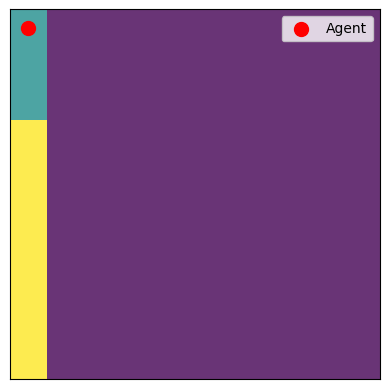

In [24]:
def update(frame, env, agent, ax):
    if not hasattr(update, "done") or not update.done:
        action = agent.choose_action(env.state)
        _, _, update.done, _ = env.step(action)
        animation_plot(env, ax)

fig, ax = plt.subplots()

# Reset the environment for the animation
env.reset()

# Create the animation
animation = FuncAnimation(fig, lambda frame: update(frame, env, agent, ax), frames=100, interval=100)

# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())

In [ ]:
def plot_q_values(agent):
    fig, axs = plt.subplots(agent.env.grid_size, agent.env.grid_size, figsize=(20, 20))

    # Iterate over all grid cells
    for i in range(agent.env.grid_size):
        for j in range(agent.env.grid_size):
            ax = axs[i, j]
            q_values = agent.q_table[i, j]

            # Use a bar chart or similar to represent Q-values for each action
            ax.bar(range(len(q_values)), q_values, color=['blue', 'green', 'red', 'purple'])
            ax.set_ylim([-100, 100])  # Assuming Q-values are in this range; adjust as needed
            ax.set_xticks(range(len(q_values)))
            ax.set_xticklabels(['Up', 'Down', 'Left', 'Right'])
            ax.set_title(f"State ({i}, {j})")

    plt.tight_layout()
    plt.show()

# Assuming your agent is named 'agent' and has been trained
plot_q_values(agent)